Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [42]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [46]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates = ['Date'], #Also, we are changing the date to the index column
                 index_col = 'Date')

In [47]:
df.shape

(423, 65)

Let's see what we are dealing with

In [48]:
df

,Location,Burrito,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Donato's taco shop,California,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,California,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carne asada,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-27,Pollos Maria,California,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,Valentine's Mexican Food,Al Pastor,NaN,NaN,NaN,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,3.50,NaN,Anon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27,Valentine's Mexican Food,Chile Relleno,NaN,NaN,NaN,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,4.00,NaN,Bonnie,non-symmetric wrapping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27,Valentine's Mexican Food,California,NaN,NaN,NaN,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,3.50,NaN,Scott,way too small and not enough meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 423 entries, 2016-01-18 to 2019-08-27
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        423 non-null    object 
 1   Burrito         423 non-null    object 
 2   Neighborhood    92 non-null     object 
 3   Address         88 non-null     object 
 4   URL             87 non-null     object 
 5   Yelp            87 non-null     float64
 6   Google          87 non-null     float64
 7   Chips           26 non-null     object 
 8   Cost            416 non-null    float64
 9   Hunger          420 non-null    float64
 10  Mass (g)        22 non-null     float64
 11  Density (g/mL)  22 non-null     float64
 12  Length          284 non-null    float64
 13  Circum          282 non-null    float64
 14  Volume          282 non-null    float64
 15  Tortilla        423 non-null    float64
 16  Temp            403 non-null    float64
 17  Meat            

In [50]:
dfrec = df.dropna(subset = ['Rec'])
dfrec['Rec'].value_counts()

Yes     157
No       67
yes       3
N         3
Y         2
yes       1
Name: Rec, dtype: int64

In [51]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [53]:
# I wanna see what these categorries look like

california

Date
2016-01-18     True
2016-01-24     True
2016-01-24    False
2016-01-24    False
2016-01-27     True
              ...  
2019-08-27    False
2019-08-27    False
2019-08-27     True
2019-08-27    False
2019-08-27    False
Name: Burrito, Length: 421, dtype: bool

In [54]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [55]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [56]:
df

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-27,California,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,Other,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2019-08-27,Other,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-27,California,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

#II. Split the Data

In [58]:
target = 'Great'
y = df[target]
X = df.drop(columns = target)

In [67]:
#Now we will split y and X into training, validation, and testing sets as per the instructions
# Do train/validate/test split. 

# Train on reviews from 2016 & earlier. 
# Validate on 2017. 
# Test on 2018 & later.

mask1 = X.index <= '2016-12-31'
mask2 = (X.index <= '2017-12-31') & (X.index >= '2017-01-01')
mask3 = X.index >= '2018-01-01'

In [68]:
X_train, y_train =  X.loc[mask1], y.loc[mask1]
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[mask3], y.loc[mask3]

In [72]:
y_train

Date
2016-01-18    False
2016-01-24    False
2016-01-24    False
2016-01-24    False
2016-01-27     True
              ...  
2016-12-02    False
2016-12-02    False
2016-12-10    False
2016-12-10    False
2016-12-15    False
Name: Great, Length: 298, dtype: bool

In [73]:
y_val

Date
2017-01-04    False
2017-01-04    False
2017-01-07    False
2017-01-07    False
2017-01-10    False
              ...  
2017-09-05     True
2017-09-05     True
2017-12-16    False
2017-12-29     True
2017-12-29     True
Name: Great, Length: 85, dtype: bool

In [71]:
y_test

Date
2026-04-25     True
2018-01-02    False
2018-01-09    False
2018-01-12     True
2018-01-12    False
2018-04-04     True
2018-04-09     True
2018-04-09     True
2018-04-09    False
2018-04-14     True
2018-04-14    False
2018-04-16    False
2018-04-16    False
2018-04-20     True
2018-04-20     True
2018-04-21     True
2018-04-21    False
2018-04-29    False
2018-04-29    False
2018-05-01    False
2018-05-07    False
2018-05-07     True
2018-05-22     True
2018-05-22     True
2018-05-22     True
2018-05-22    False
2018-05-22    False
2018-11-06     True
2019-08-24     True
2019-08-27     True
2019-08-27     True
2019-08-27     True
2019-08-27     True
2019-08-27    False
2019-08-27     True
2019-08-27    False
2019-08-27     True
2019-08-27     True
Name: Great, dtype: bool

#III. Establish Baseline

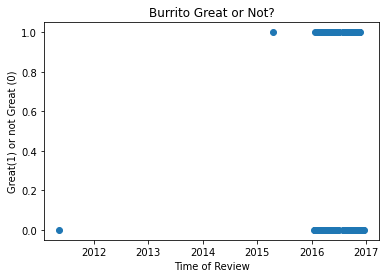

In [82]:
# Let's see a visualization of what we have here
import matplotlib.pyplot as plt
plt.scatter(y_train.index, y_train)
plt.xlabel('Time of Review')
plt.ylabel('Great(1) or not Great (0)')
plt.title('Burrito Great or Not?');

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = [y_train.mean()] * len(y_train)
print('Mean Greatness',y_train.mean())
print('Baseline MAE', mean_absolute_error(y_train, y_pred))

print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Mean Greatness 0.40939597315436244
Baseline MAE 0.4835818206387099
Baseline Accuracy Score: 0.5906040268456376


#IV. Build Models

In [84]:
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.imput import SimpleImputer #Look up documentation
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Since this is a Classification questions, we will use Logistic Regression

In [86]:
#Let's build the pipe for the data to run through
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(strategy = 'mean'),
    LogisticRegression()
)

model.fit(X_train,  y_train)


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito', 'Chips', 'Unreliable', 'NonSD',
                                     'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
                                     'Sour cream', 'Pork', 'Chicken', 'Shrimp',
                                     'Fish', 'Rice', 'Beans', 'Lettuce',
                                     'Tomato', 'Bell peper', 'Carrots',
                                     'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
                                     'Onion', 'Taquito', 'Pineapple', 'Ham',
                                     'Chile relleno', 'Nopales', ...],
                               dr...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, d

#V. Check Results (Metrics)

In [87]:
print('Training Accuracy', model.score(X_train, y_train))
print('Validation Accuracy', model.score(X_val, y_val))
print('Test Accuracy', model.score(X_test, y_test))

Training Accuracy 0.9093959731543624
Validation Accuracy 0.8117647058823529
Test Accuracy 0.7631578947368421
